# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

### Running for Bristol 

For Bristol there should be 1495 rows in the results. There are 2644 rows in the original listings file, but 1149 of them have no description for the neighbourhood overview or 

In [2]:
city='bristol'
lsoas =  gpd.read_file('../../data/Bristol_LSOAs/Lower_Layer_Super_Output_Areas_2011_(Precise).shp')

In [3]:
base_dir = os.path.expanduser(f"../../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_01.csv')
overall_df = gentrication_cat_df

### Convert to geodataframe

In [4]:
overall_df['geometry'] = overall_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(overall_df, geometry='geometry', crs="EPSG:4326")
overall_gdf = overall_gdf.to_crs(lsoas.crs)
overall_gdf = gpd.sjoin(overall_gdf, lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

### Add:
- Word instead of code

In [5]:
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
overall_gdf['gentrification_prediction_code'] = overall_gdf['gentrification_prediction'].map(mapping)

In [6]:
lsoa_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
lsoas = lsoas.merge(lsoa_scores_gentrification, on='LSOA11NM', how='left')
lsoas = lsoas.sort_values(by='LSOA11NM')

### Read in socio-economic data

In [7]:
indicators = pd.read_csv("../../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_bristol = indicators[indicators['LA_NAME'] =='Bristol, City of'].copy()
indicators_bristol = indicators_bristol.rename(columns={"LSOA": 'LSOA11CD'})
indicators_bristol = indicators_bristol.merge(lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')
indicators_bristol.sort_values(by='gentrification_prediction_code', inplace=True)
del indicators_bristol['Churn_2020']

### Rescale values between 0 and 1

In [8]:
# numeric_cols = indicators_bristol.columns
# numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])
# indicators_bristol[numeric_cols] = (indicators_bristol[numeric_cols] - indicators_bristol[numeric_cols].min()) / \
#                                    (indicators_bristol[numeric_cols].max() - indicators_bristol[numeric_cols].min())

# # scaler = StandardScaler()
# # indicators_bristol[numeric_cols] = scaler.fit_transform(indicators_bristol[numeric_cols])

In [9]:
# 1. Identify numeric columns
numeric_cols = indicators_bristol.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])

# 2. Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
scaled_minmax = minmax_scaler.fit_transform(indicators_bristol[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_minmax_df = pd.DataFrame(scaled_minmax, columns=numeric_cols)
indicators_bristol_minmax = pd.concat([indicators_bristol[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_minmax_df], axis=1)

# 3. Apply StandardScaler
standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_bristol[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_bristol_standard = pd.concat([indicators_bristol[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_standard_df], axis=1)

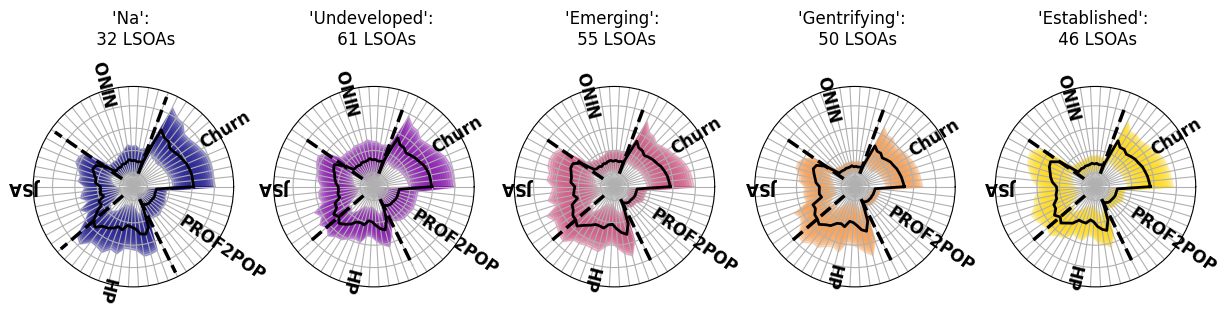

In [10]:
# pattern = '|'.join(['Manchester', 'Stockport', 'Salford', 'Trafford', 'Tameside'])
# indicators_manchester_filtered = indicators_manchester[indicators_manchester['LA_NAME'].str.contains(pattern)] 

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol_minmax[indicators_bristol_minmax['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],numeric_cols)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

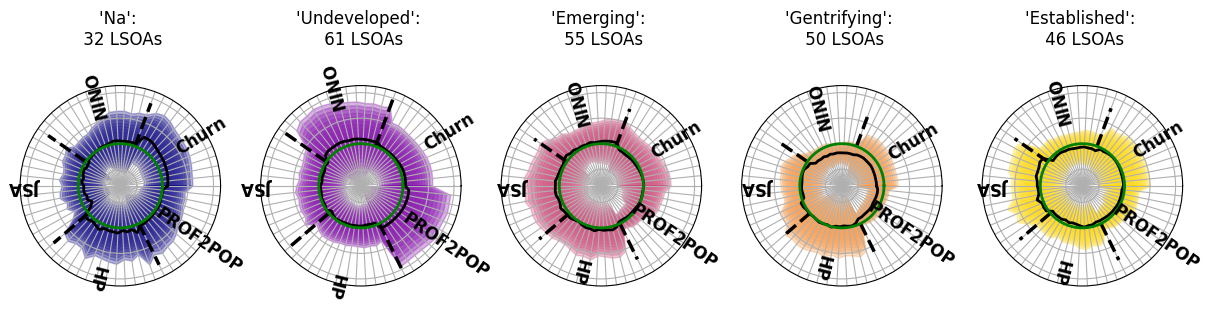

In [36]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],numeric_cols)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)
        ax.plot(np.linspace(0, 2 * np.pi, 100), np.zeros(100), color='green', linewidth=2)

### Create version with the mean across years

In [36]:
indicators_bristol_short = indicators_bristol.copy()

# Dictionary of variable prefixes and their year ranges
variables = {'PROF2POP': range(2010, 2021),'Churn': range(2008, 2021), 'NINO': range(2008, 2021), 'JSA': range(2008, 2021),'HP': range(2008, 2021)}

# Loop over each variable type to compute mean
for var, years in variables.items():
    cols = [f"{var}_{year}" for year in years]
    indicators_bristol_short[f'{var}_mean'] = indicators_bristol_short[cols].mean(axis=1)
    # To also compute std, uncomment the line below
    # indicators_bristol_short[f'{var.lower()}_std'] = indicators_bristol_short[cols].std(axis=1)

# Drop all original year columns
all_cols = [f"{var}_{year}" for var, years in variables.items() for year in years]
indicators_bristol_short.drop(columns=all_cols, inplace=True)

### Create version with just one of each variable 'group'

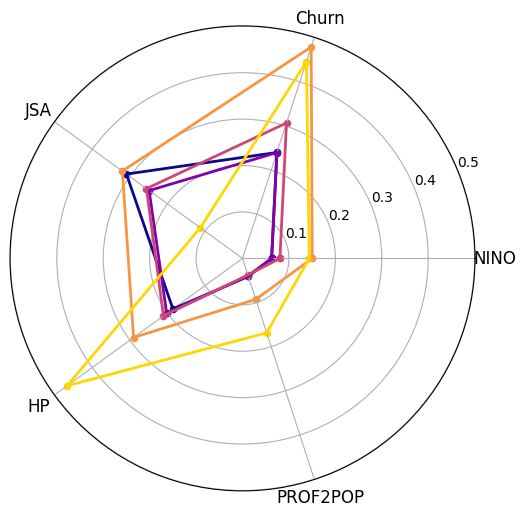

In [37]:
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

# Example usage for creating plots
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},figsize=(6,8), sharex=True, sharey=True)

for gentr_class, val in enumerate(np.unique(indicators_bristol_short['gentrification_prediction_code'])):
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data)>0:
        plot_mean_rose_plot(ax, class_data, plot_colors[gentr_class], just_means=True)

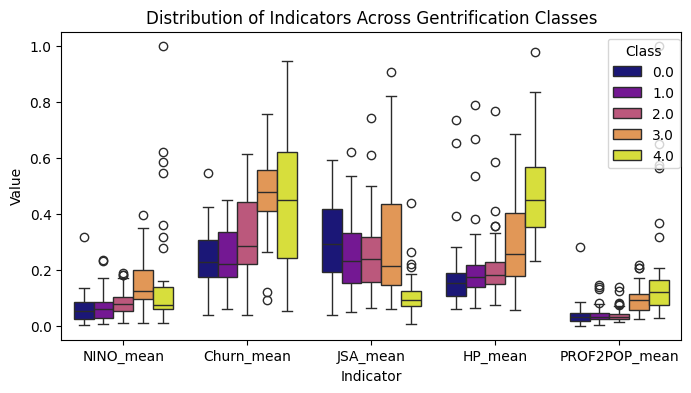

In [38]:
# Melt the dataframe to long format for seaborn
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

# Select relevant columns + gentrification class
df_melted = indicators_bristol_short[['gentrification_prediction_code'] + variables].melt(id_vars='gentrification_prediction_code', 
                                     value_vars=variables, var_name='Indicator',  value_name='Value')

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_melted, 
            x='Indicator', 
            y='Value', 
            hue='gentrification_prediction_code', 
            palette='plasma')  # or any nice palette like 'Set2', 'coolwarm'

plt.title('Distribution of Indicators Across Gentrification Classes')
plt.legend(title='Class', bbox_to_anchor=(0.87, 1), loc='upper left')

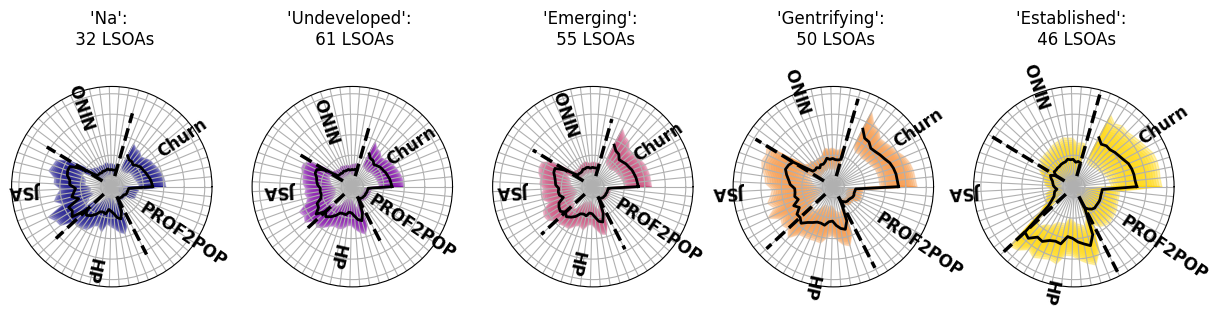

In [39]:
variables = indicators_bristol.columns
to_be_removed = {'LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'}
variables = [item for item in variables if item not in to_be_removed ]

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol[indicators_bristol['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_with_group_labels(ax, class_data, plot_colors[gentr_class],variables)
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

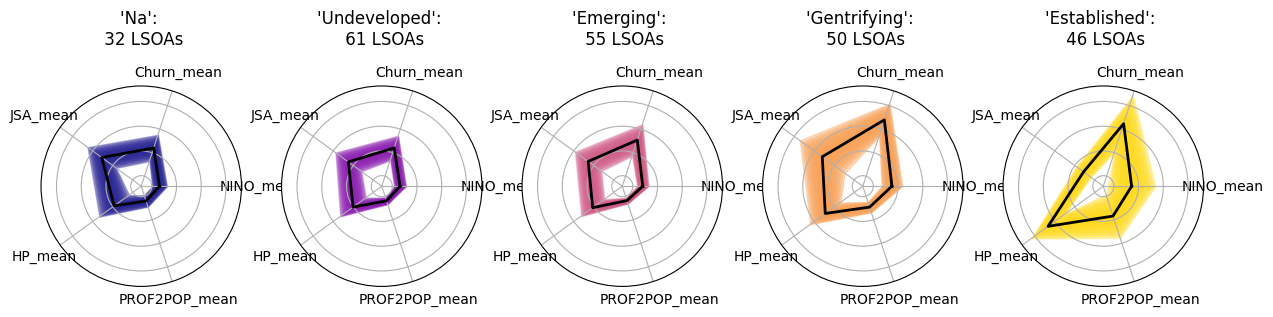

In [40]:
variables = ['NINO_mean', 'Churn_mean', 'JSA_mean', 'HP_mean', 'PROF2POP_mean']

fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=5, nrows=1, figsize=(15,10), sharex=True, sharey=True)

for gentr_class, ax in enumerate(axs.flatten()):
    class_data = indicators_bristol_short[indicators_bristol_short['gentrification_prediction_code'] == gentr_class]
    if len(class_data) == 0:
        ax.set_axis_off()
    else:
        plot_mean_rose_plot_with_gradient(ax, class_data, variables, plot_colors[gentr_class])
        key = [k for k, v in mapping.items() if v == gentr_class][0]
        ax.set_title(f"'{key}': \n {len(class_data)} LSOAs", size=12, pad=30)

In [51]:
from matplotlib.lines import Line2D

# Define variable categories (based on column names or your own grouping logic)
variable_categories = {
    'Churn': [col for col in indicators_bristol_standard.columns if 'Churn' in col],
    'NINO': [col for col in indicators_bristol_standard.columns if 'NINO' in col],
    'JSA': [col for col in indicators_bristol_standard.columns if 'JSA' in col],
    'HP': [col for col in indicators_bristol_standard.columns if 'HP' in col],
    'PROF2POP': [col for col in indicators_bristol_standard.columns if 'PROF2POP' in col]
}

# Compute mean and std for all areas
areas = { "NA": indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == 0],
    "Undeveloped": indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == 1],
    "Emerging": indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == 2],
    "Gentrifying": indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == 3],
    "Established": indicators_bristol_standard[indicators_bristol_standard['gentrification_prediction_code'] == 4],
    'All': indicators_bristol_standard}

# Compute mean and std for all areas
stats = {}
for area, df in areas.items():
    stats[area] = {
        "Mean": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean(),
        "Std": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std(),
        'len': len(df)}
area_colors = {"NA": plot_colors[0],"Undeveloped": plot_colors[1],"Emerging": plot_colors[2],"Gentrifying": plot_colors[3],"Established": plot_colors[4],'All': 'k' }


In [59]:
stats['Established']['Mean']

Churn_2008      -0.039180
Churn_2009      -0.044128
Churn_2010      -0.050723
Churn_2011      -0.052663
Churn_2012      -0.043317
                   ...   
PROF2POP_2016   -0.084413
PROF2POP_2017   -0.086178
PROF2POP_2018   -0.083632
PROF2POP_2019   -0.088189
PROF2POP_2020   -0.093291
Length: 62, dtype: float64

NA
Undeveloped
Emerging
Gentrifying
Established
All


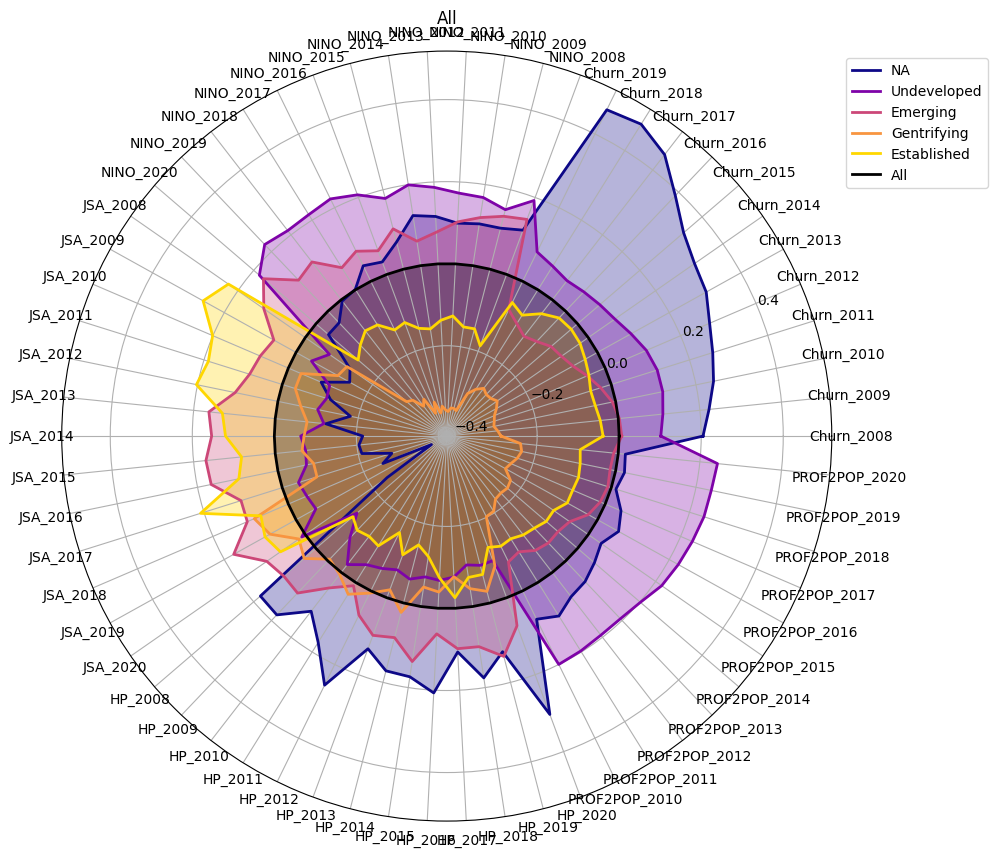

In [61]:
def plot_radar(ax, stats, area_name, color):
    """
    Plots a radar chart for a given area's statistics.
    
    Parameters:
        ax (matplotlib.axes._subplots.AxesSubplot): The subplot axis to plot on.
        stats (pd.Series): A series containing the mean values of the variables.
        area_name (str): The name of the area (for the title).
        color (str): The color for the plot.
    """
    # Get the number of variables
    labels = stats.index
    num_vars = len(labels)
    
    # Compute angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    stats_values = stats.values.tolist()
    
    # Close the radar chart shape
    angles += angles[:1]
    stats_values += stats_values[:1]
    
    # Plot
    #ax.set_theta_offset(np.pi / 2)  # Rotate to start from top
    #ax.set_theta_direction(-1)  # Clockwise direction
    ax.plot(angles, stats_values, linewidth=2, linestyle='solid', label=area_name, color=color)
    ax.fill(angles, stats_values, alpha=0.3, color=color)
    
    # Set labels and remove radial grid
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_title(area_name, size=12, pad=20)

# Compute means for each area
area_means = {area: df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean() for area, df in areas.items()}
area_stds=  {area: df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std() for area, df in areas.items()}

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': 'polar'}, sharey=True)

for (area, mean_values), color in zip(area_means.items(), plot_colors +['black']):
    print(area)
    plot_radar(ax, mean_values, area, color)

custom_legend = [Line2D([0], [0], color=area_colors[area], lw=2, label=area) for area in areas]

# Add the custom legend to the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.01, 1), loc='upper left')

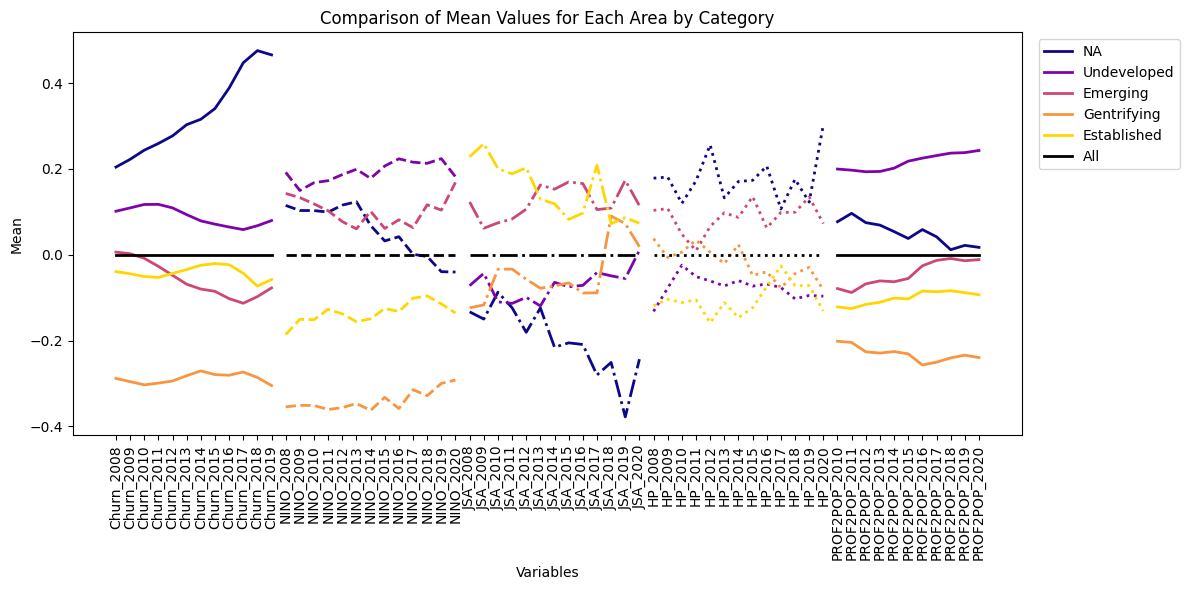

In [63]:
from matplotlib.lines import Line2D

# Compute mean and std for all areas
stats = {}
for area, df in areas.items():
    stats[area] = {
        "Mean": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean(),
        "Std": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std(),
        'len': len(df)}

# Plot means for all areas, with grouping by categories
plt.figure(figsize=(12, 6))

# Different line styles for categories
category_styles = {'Churn': '-', 'NINO': '--', 'JSA': '-.', 'HP': ':', 'PROF2POP': '-'}

# Different colors for areas
area_colors = {"NA": plot_colors[0],"Undeveloped": plot_colors[1],"Emerging": plot_colors[2],"Gentrifying": plot_colors[3],"Established": plot_colors[4],'All': 'k' }

# Plot lines for each area with different categories
for area, stat in stats.items():
    # Plot each category separately
    for category, variables in variable_categories.items():
        # Extract mean values for this category
        category_mean = stat["Mean"][variables]
        
        # Plot with the corresponding color for the area and linestyle for the category
        plt.plot(category_mean, label=f'{area} - {category}', 
                 color=area_colors[area], linestyle=category_styles[category], linewidth=2)

# Rotate x-axis labels and adjust the layout
plt.xticks(rotation=90)
custom_legend = [Line2D([0], [0], color=area_colors[area], lw=2, label=area) for area in areas]

# Add the custom legend to the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel('Variables')
plt.ylabel('Mean')
plt.title('Comparison of Mean Values for Each Area by Category')

plt.tight_layout()
plt.show()


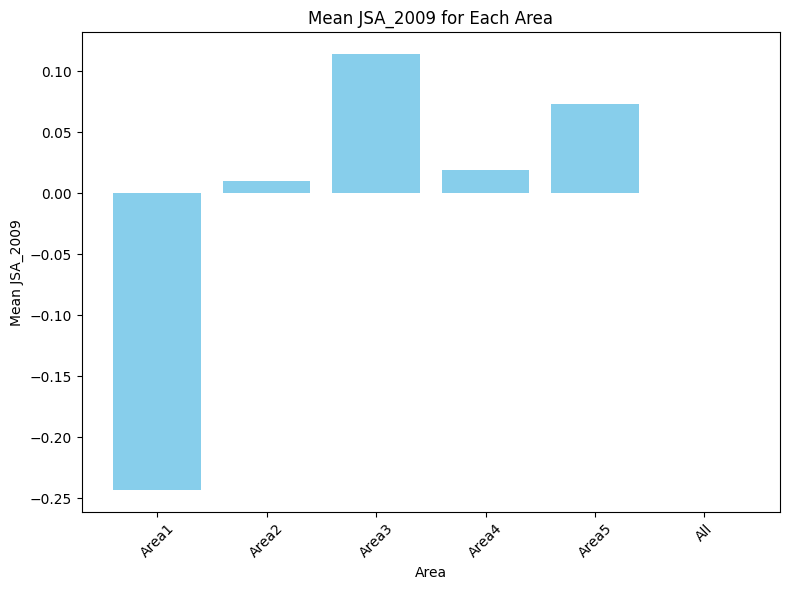

In [70]:
import matplotlib.pyplot as plt

df = indicators_bristol_standard
# Define the areas
areas = {
    "Area1": df[df['gentrification_prediction_code'] == 0],
    "Area2": df[df['gentrification_prediction_code'] == 1],
    "Area3": df[df['gentrification_prediction_code'] == 2],
    "Area4": df[df['gentrification_prediction_code'] == 3],
    "Area5": df[df['gentrification_prediction_code'] == 4],
    "All": df
}

# Compute the mean of JSA_2009 for each area
mean_jsa_2009 = {area: df['JSA_2020'].mean() for area, df in areas.items()}

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(mean_jsa_2009.keys(), mean_jsa_2009.values(), color='skyblue')

# Labels and title
plt.xlabel('Area')
plt.ylabel('Mean JSA_2009')
plt.title('Mean JSA_2009 for Each Area')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


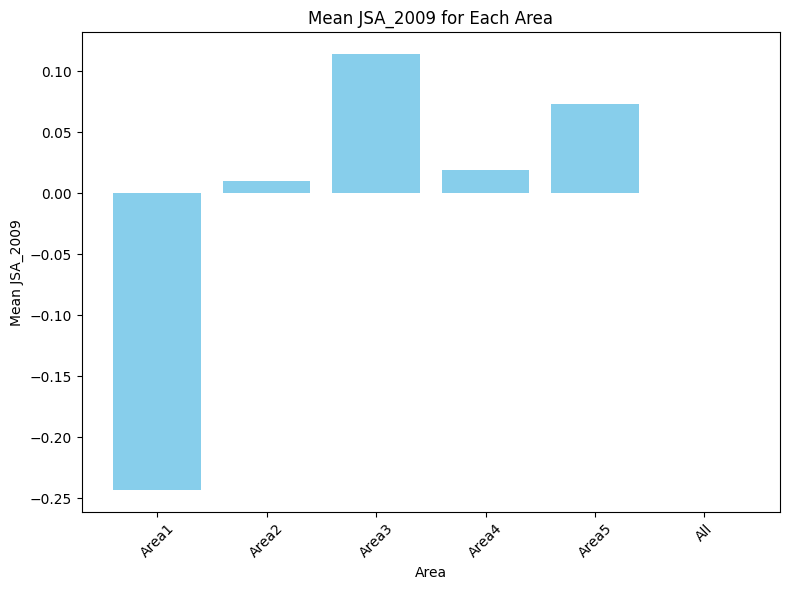

In [71]:
# Compute the mean of JSA_2009 for each area
mean_jsa_2009 = {area: df['JSA_2020'].mean() for area, df in areas.items()}

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(mean_jsa_2009.keys(), mean_jsa_2009.values(), color='skyblue')

# Labels and title
plt.xlabel('Area')
plt.ylabel('Mean JSA_2009')
plt.title('Mean JSA_2009 for Each Area')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()